# Multi Layer Perceptron

## one hot encoding
하나만 1, 나머지는 전부 0이 되도록 encoding

In [2]:
import numpy as np
from collections import defaultdict

def encode_one_hot(train_set, classes="AGCT"):
    encoder = defaultdict(lambda: np.array([0]*len(classes)))
    
    for i, _class in enumerate(classes):
        tmp = np.zeros(len(classes))
        tmp[i] = 1
        encoder[_class] = tmp
    output = []
    for record in train_set:
        encoded_record = []
        
        for c in record:
            encoded_record.append(encoder[c])
        
        output.append(encoded_record)
    
    output = np.array(output)
    
    return output

## Data load

### 형태 
|FoldID |EventID            |seq	                |Bound  |
|-------|-------------------|-----------------------|-------|
|B      |seq_000000_peak    |AATTAACCTACTAATTGGAT   |	1   |
|B      |seq_000000_shuf    |ACTAAAACCTGGATATTATT   |	0   |
|...    |...                |...                    | ...   |

* 50000개의 염기서열 데이터 

1. seq(길이 20의 염기서열 문자열)의 문자(A, G, C, T)를 onehotencoding 수행   
    한 데이터 당 (20x4)의 one hot encoding된 배열 생성됨
2. bound를 y 값으로 처리


In [17]:
import gzip
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# single dataset version
def get_dataset(path):
    dataset = gzip.open(path, "r")
    output = []
    for i, record in tqdm(enumerate(dataset)):
        record = record.decode()
        record = record[:-1]
        record = record.split('\t')
        if i != 0:
            output.append(record)
    output = np.array(output).reshape([-1, 4])

    return encode_one_hot(output[:, 2]), np.array(output[:, 3]).flatten()

x, y = get_dataset("./dataset_mini.gz")
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.33, random_state=112)

del(x, y)

print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

50001it [00:00, 408553.29it/s]


(33500, 20, 4)
(33500,)
(16500, 20, 4)
(16500,)


## Reshape

In [7]:
from tensorflow.keras.utils import to_categorical

train_x = train_x.reshape(-1, 80)
test_x = test_x.reshape(-1, 80)

train_y = to_categorical(train_y, 2)
test_y = to_categorical(test_y, 2)

print("Train Set | x:", train_x.shape, ", y:", train_y.shape)
print("Valid Set | x:", test_x.shape, ", y:", test_y.shape)

Train Set | x: (33500, 80) , y: (33500, 2)
Valid Set | x: (16500, 80) , y: (16500, 2)


## MLP

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def MLP_model(unit, hidden, input_shape):
  # 층(layer)을 차례대로 쌓는 모델 객체 생성
  model = tf.keras.Sequential()
  
  # 완전 연결층(fully connected layer) 추가
  # units: 출력 뉴런의 수
  # input_dim: 입력 데이터의 특성 수
  # activation: 활성화 함수
  model.add(layers.Dense(units=unit, input_dim=input_shape, activation='relu'))

  for i in range(1, hidden + 1):
    model.add(layers.Dense(units=unit, kernel_initializer='glorot_uniform', activation='relu'))
  
  model.add(layers.Dense(units=2, kernel_initializer='glorot_uniform', activation='softmax'))
  # optimizer: 최적화 함수 adam(Adaptive Moment Estimation)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [5]:
model = MLP_model(unit=20, hidden=3, input_shape=train_x.shape[1])
history = model.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
838/838 [==============================] - 1s 854us/step - loss: 0.5464 - accuracy: 0.7116 - val_loss: 0.4394 - val_accuracy: 0.7978
Epoch 2/10
838/838 [==============================] - 1s 717us/step - loss: 0.4095 - accuracy: 0.8196 - val_loss: 0.3921 - val_accuracy: 0.8288
Epoch 3/10
838/838 [==============================] - 1s 715us/step - loss: 0.3727 - accuracy: 0.8396 - val_loss: 0.3799 - val_accuracy: 0.8334
Epoch 4/10
838/838 [==============================] - 1s 722us/step - loss: 0.3519 - accuracy: 0.8518 - val_loss: 0.3634 - val_accuracy: 0.8425
Epoch 5/10
838/838 [==============================] - 1s 718us/step - loss: 0.3369 - accuracy: 0.8575 - val_loss: 0.3561 - val_accuracy: 0.8463
Epoch 6/10
838/838 [==============================] - 1s 721us/step - loss: 0.3248 - accuracy: 0.8634 - val_loss: 0.3542 - val_accuracy: 0.8476
Epoch 7/10
838/838 [==============================] - 1s 752us/step - loss: 0.3156 - accuracy: 0.8674 - val_loss: 0.3442 - val_accuracy:

## Loss & Accuracy

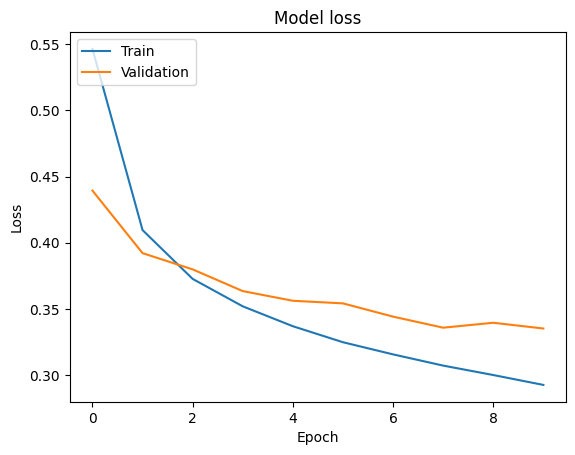

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

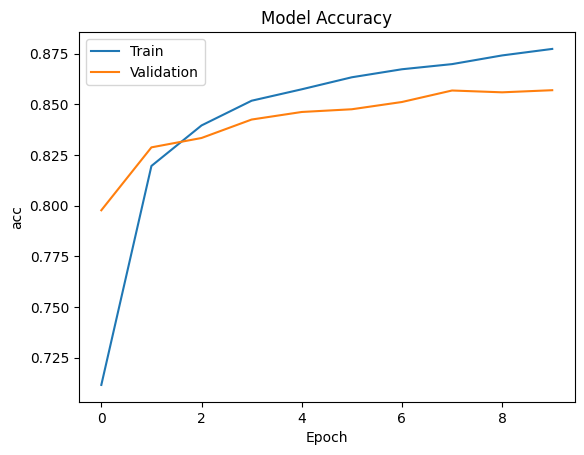

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Test set

In [8]:
score = model.evaluate(test_x, test_y)
print('test loss:', score[1])

516/516 [==============================] - 0s 521us/step - loss: 0.3312 - accuracy: 0.8584
test loss: 0.8584242463111877


In [9]:
history = model.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
838/838 [==============================] - 1s 753us/step - loss: 0.2876 - accuracy: 0.8788 - val_loss: 0.3335 - val_accuracy: 0.8606
Epoch 2/10
838/838 [==============================] - 1s 734us/step - loss: 0.2828 - accuracy: 0.8807 - val_loss: 0.3327 - val_accuracy: 0.8615
Epoch 3/10
838/838 [==============================] - 1s 738us/step - loss: 0.2795 - accuracy: 0.8838 - val_loss: 0.3673 - val_accuracy: 0.8482
Epoch 4/10
838/838 [==============================] - 1s 737us/step - loss: 0.2768 - accuracy: 0.8861 - val_loss: 0.3324 - val_accuracy: 0.8627
Epoch 5/10
838/838 [==============================] - 1s 748us/step - loss: 0.2719 - accuracy: 0.8874 - val_loss: 0.3331 - val_accuracy: 0.8618
Epoch 6/10
838/838 [==============================] - 1s 742us/step - loss: 0.2700 - accuracy: 0.8873 - val_loss: 0.3233 - val_accuracy: 0.8628
Epoch 7/10
838/838 [==============================] - 1s 728us/step - loss: 0.2685 - accuracy: 0.8891 - val_loss: 0.3267 - val_accuracy:

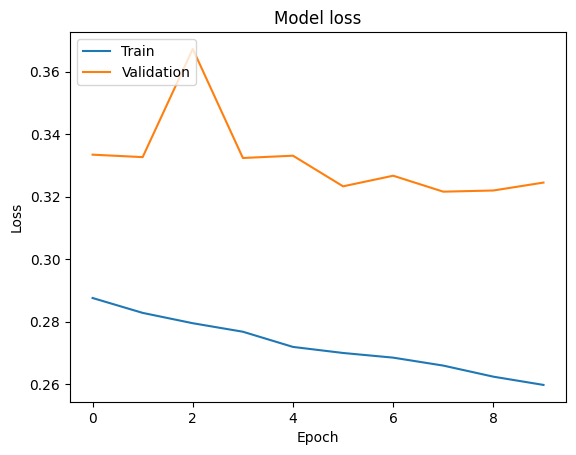

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

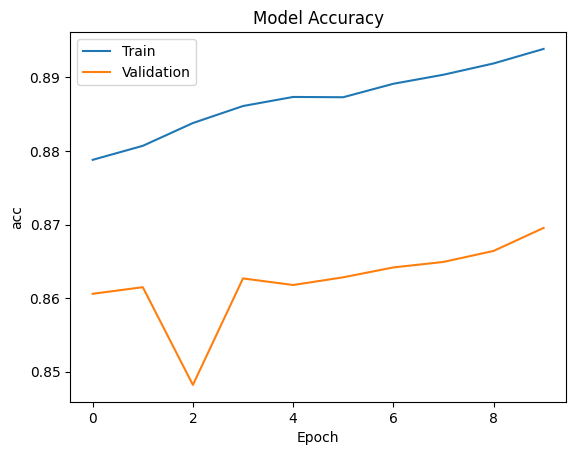

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
score = model.evaluate(test_x, test_y)
print('test loss:', score[1])

516/516 [==============================] - 0s 505us/step - loss: 0.3223 - accuracy: 0.8638
test loss: 0.8637575507164001
